# Seminario 
## Inferencia de Redes

Parte práctica Aracne en R.

A partir de datos obtenidos de GeneNetWeaver (50 genes y 2100 muestras de levadura) vamos a inferir una red de co-expresión que compararemos con su red real.

#### Se cargan librerías

In [1]:
#Cargo las librerías necesarias

library(infotheo)

In [2]:
#Cargo las librerías necesarias

library(minet)

In [3]:
#Cargo las librerías necesarias

library(igraph)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



### Cargar datos
Lo primero es **cargar datos**, en este caso, la tabla con todos los datos de niveles de expresión de los 50 genes.

In [4]:
#Cargo datos (50 genes y 2100 muestras)

matriz <- read.table("datos_tchan/50_yeast3_large.txt", header = FALSE, row.names = 1)

colnames(matriz) <- paste0("S", 1:length(colnames(matriz)))

In [ ]:
#Conversión


matriz <- as.matrix(matriz)

In [ ]:
head(matriz)

Ahora crearemos una matriz vacía con dimensión 50x50 (correspondiente al número de genes) para posteriormente guardar los valores de MI para cada par de genes.

In [5]:
#Se crea matriz vacía para MI

matriz_MI <- matrix(nrow = 50, ncol = 50)
colnames(matriz_MI) <- rownames(matriz)
rownames(matriz_MI) <- rownames(matriz)

### Estimación de MI
Función para estimar los valores de MI entre cada par de genes.

Notemos que primero tomamos el renglón correspondientes a cada gen por analizar y se ***discretiza***.

In [11]:
#Se calcula MI

for(i in 1:50){
  for(j in 1:50){
      
    var.a <- matriz[i,]
    var.b <- matriz[j,]
    
    var.a <- discretize(var.a, disc = "equalwidth") #Discretización de la v.a. g1
    var.b <- discretize(var.b, disc = "equalwidth") #Discretización de la v.a. g2
    
    mutual_info <- mutinformation(X = var.a, Y = var.b, method = "shrink")
    
    matriz_MI[i,j] <- mutual_info
  }
}

ERROR: Error in if (res < 0) res <- 0: valor ausente donde TRUE/FALSE es necesario


In [8]:
#Se elimina la diagonal

diag(matriz_MI) <- 0

Graficamos la red que obtenemos.

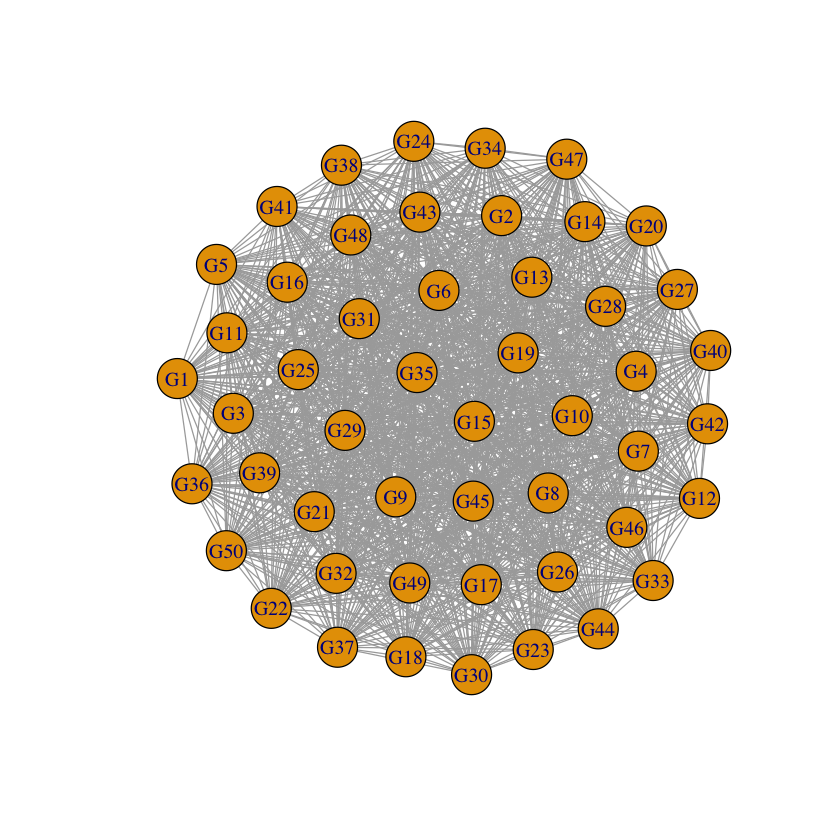

In [9]:
#Veamos la red

g0 <- graph_from_adjacency_matrix(matriz_MI, mode = "undirected", weighted = TRUE)
plot(g0)

### Filtro: Umbral

Calculamos el umbral estadístico con el cual haremos el primer filtro.

In [10]:
#Filtro 1. Cálculo del umbral estadístico (15%)

mi_0 <- quantile(matriz_MI, 0.85)
mi_0

ERROR: Error in quantile.default(matriz_MI, 0.85): missing values and NaN's not allowed if 'na.rm' is FALSE


In [ ]:
#Se guarda la matriz original de MI

matriz_MI0 <- matriz_MI

**Filtramos** "Eliminaremos" todas las entradas de la matriz_MI cuyos valores sean menores al umbral establecido.

In [ ]:
# Filtro 1. Se eliminan entradas por debajo del umbral.

for(i in 1:50){
  for (j in 1:50) {
      
    if(matriz_MI[i, j] < mi_0){
      matriz_MI[i, j] = 0
    } else{
      matriz_MI[i, j] = matriz_MI[i, j]
    }
  }
}

¿Quitamos enlaces?

In [ ]:
#Comparación

table(matriz_MI0 == matriz_MI)

Graficamos la red después del primer filtro.

In [ ]:
#Veamos la red

g1 <- graph_from_adjacency_matrix(matriz_MI, mode = "undirected", weighted = TRUE)
plot(g1)

## Hasta aquí hemos inferido una red con Relevance Networks.

### Filtro: DPI

De tripletes de genes conectados (triángulos) se busca el enlace con menos MI y si éste es además menor que un umbral establecido, se elimina.

Aquí usamos la función ***aracne*** de la librería *minet*, la cual hace **DPI**.

In [ ]:
#Filtro 2. DPI (aracne)

inf_net <- aracne(matriz_MI, eps = 0.05)

Finalmente, graficamos la red inferida tras DPI.

In [ ]:
#Graficamos

g_inf <- graph_from_adjacency_matrix(inf_net, mode = "undirected", weighted = TRUE)
plot(g_inf)

### Ahora sí, ya podemos decir: 

 
 
## ¡Hemos inferido una red por medio del algoritmo 
# ARACNE!  =)

#### Ahora vamos a comparar con la red real.
 
Primero cargamos los datos.

In [ ]:
#Cargo datos de la red real

matriz_real <- read.table("datos_tchan/50_yeast3.tsv", header = FALSE)

In [ ]:
matriz_real

Graficamos la red.

In [ ]:
#Graficamos la red real 

g_real <- graph_from_data_frame(matriz_real, directed = FALSE)
plot(g_real)

Eliminamos los enlaces con MI = 0, pues los dibujó.

In [ ]:
#Se eliminan los enlaces con MI = 0

g_real <- delete_edges(g_real, E(g_real)[V3 == 0])

#### Graficamos la red real

In [ ]:
#Se grafica g_real

plot(g_real)

In [ ]:
#Gráfica de la red inferida
plot(g_inf)

Haremos algunas *comparaciones*.

In [ ]:
#Se obtienen las matrices de adyacencia de ambas redes

real.matrix <- get.adjacency(g_real)
g_inf.matrix <- get.adjacency(g_inf)

In [ ]:
#Chequemos si son iguales

table(as.matrix(real.matrix == g_inf.matrix))

Más *comparaciones*.

In [ ]:
#Verdaderos positivos

length(which(as.matrix(real.matrix) == 1 & as.matrix(g_inf.matrix) == 1))

In [ ]:
#Falsos negativos

length(which(as.matrix(real.matrix) == 1 & as.matrix(g_inf.matrix) == 0))

In [ ]:
#Falsos positivos

length(which(as.matrix(real.matrix) == 0 & as.matrix(g_inf.matrix) == 1))

In [ ]:
#Verdaderos negativos

length(which(as.matrix(real.matrix) == 0 & as.matrix(g_inf.matrix) == 0))

# ¡Gracias!